In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras.applications import imagenet_utils
from keras import Model
import warnings
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import Image
%matplotlib inline

In [13]:
def get_data(nameDir):
    """
    ===================================
    This function will download 1000 images per letter and digit, in a directory named "nameDir".
    Downloaded images will consist of single digits
    Directory of small letters will be named as small{letter}. For e.g. smalla
    Similary, directory of small letters will be named as cap{letter}. For e.g. capA
    Directory of digits will be named as {digit}. For e.g. 1
    ===================================
    """
    import requests,os,cv2,shutil
    base="https://aims.iith.ac.in/aims/captcha/getCaptchaByString/"
    dir_path = os.path.join(os.getcwd(),nameDir)
    if not os.path.exists(dir_path):
        os.mkdir(dir_path,0o666)
    for i in range(48,123):
        if ((i>=48 and i<=57) or (i>=65 and i<=90) or (i>=97 and i<=122)):
            ch=chr(i)
            if (i>=65 and i<=90):
                save_path=os.path.join(dir_path,f"cap{ch}")
            elif (i>=97 and i<=122):
                save_path=os.path.join(dir_path,f"small{ch}")
            else: save_path=os.path.join(dir_path,f"{ch}")
            if not os.path.exists(save_path):
                os.mkdir(save_path,mode=0o777)
#             else:
#                 li=os.listdir(save_path)
#                 if len(li)==1000: continue
            s=""
            for k in range(5):
                s+=ch
            url=base+s
            for j in range(20):
                r = requests.get(url, stream = True)
                if r.status_code == 200:
                    r.raw.decode_content = True
                    with open(os.path.join(save_path,f"{ch}#.jpg"),'wb') as f:
                        shutil.copyfileobj(r.raw, f)
                    img=cv2.imread(os.path.join(save_path,f"{ch}#.jpg"))
                    height,width,c=img.shape
                    width_cutoff=width // 5
                    s1=img[:,:width_cutoff]
                    cv2.imwrite(f"{save_path}/{5*j+1}.jpg",s1)
                    for k in range(1,4):
                        s1=img[:,k*width_cutoff:(k+1)*width_cutoff]
                        cv2.imwrite(f"{save_path}/{5*j+k+1}.jpg",s1)
                    s1=img[:,4*width_cutoff:]
                    cv2.imwrite(f"{save_path}/{5*j+5}.jpg",s1)
                    os.remove(os.path.join(save_path,f"{ch}#.jpg"))
                else:
                    print(f'Image Couldn\'t be retreived: {ch}#.jpg')
    return

In [ ]:
# Download files
get_data("data")

In [15]:
li = os.listdir("train/")
for dr in li:
    temp = os.listdir(f"train/{dr}/")
    for i in range(740):
        os.remove(f"train/{dr}/{temp[i]}")

In [17]:
# Make the val directory
if os.path.isdir('val/0') is False:
    os.mkdir('val/')
    li=listdir('train/')
    for i in li:
        os.mkdir(f'val/{i}/')
        tempLi=listdir(f'train/{i}/')
        for img in random.sample(tempLi,15):
            shutil.move(f'train/{i}/{img}',f'val/{i}/')

# Make the test directory
if os.path.isdir('test/0') is False:
    os.mkdir('test/')
    li = listdir('train/')
    for i in li:
        os.mkdir(f'test/{i}/')
        tempLi = listdir(f'train/{i}')
        for img in random.sample(tempLi,5):
            shutil.move(f'train/{i}/{img}',f'test/{i}/')

In [151]:
train_path='train/'
valid_path='val/'
test_path='test/'
train_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path,
                                                                                                                           target_size=(50,30),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path,
                                                                                                                        target_size=(50,30),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path,
                                                                                                                        target_size=(50,30),batch_size=10, shuffle = False)

Found 4960 images belonging to 62 classes.
Found 930 images belonging to 62 classes.
Found 310 images belonging to 62 classes.


In [50]:
imgs, labels = next(test_batches)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(50,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

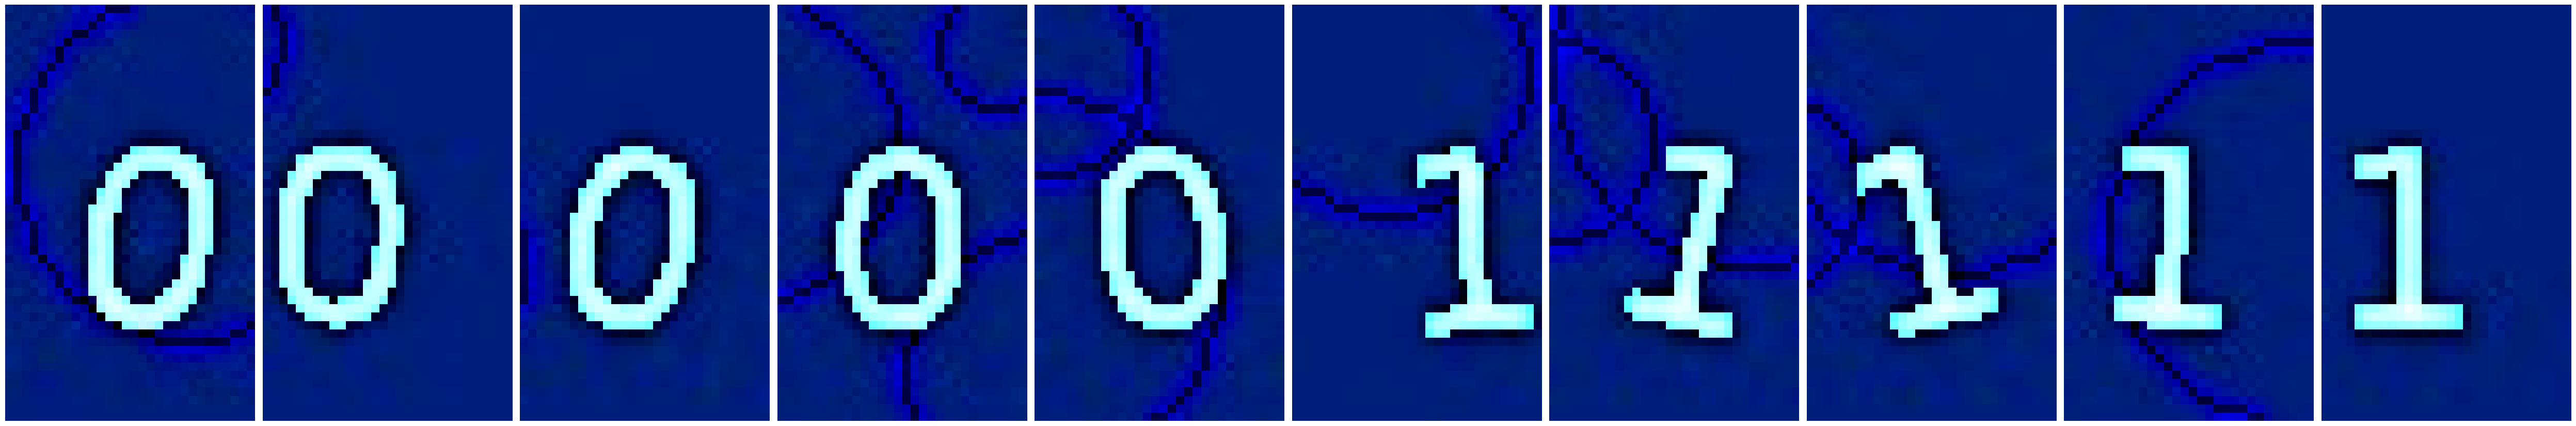

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [51]:
plotImages(imgs)
print(labels)

In [152]:
model=Sequential([
    Conv2D(filters = 64, kernel_size = (4,4), activation='relu', padding = "same", input_shape=(50,30,3)),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.25),
#     Conv2D(filters = 128, kernel_size = (4,4), activation='relu'),
#     BatchNormalization(),
#     MaxPool2D(),
#     Dropout(0.25),
    Flatten(),
    Dense(units=62,activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x=train_batches,validation_data=valid_batches,epochs=15,verbose=2)
# model.summary()

Epoch 1/15
496/496 - 87s - loss: 2.0983 - accuracy: 0.6258 - val_loss: 0.5398 - val_accuracy: 0.8462 - 87s/epoch - 175ms/step
Epoch 2/15
496/496 - 32s - loss: 0.3110 - accuracy: 0.9230 - val_loss: 0.5444 - val_accuracy: 0.8581 - 32s/epoch - 65ms/step
Epoch 3/15
496/496 - 15s - loss: 0.1706 - accuracy: 0.9573 - val_loss: 0.1872 - val_accuracy: 0.9624 - 15s/epoch - 31ms/step
Epoch 4/15
496/496 - 17s - loss: 0.1067 - accuracy: 0.9722 - val_loss: 0.4110 - val_accuracy: 0.9204 - 17s/epoch - 34ms/step
Epoch 5/15
496/496 - 15s - loss: 0.1699 - accuracy: 0.9607 - val_loss: 4.1715 - val_accuracy: 0.6108 - 15s/epoch - 30ms/step
Epoch 6/15
496/496 - 15s - loss: 0.2200 - accuracy: 0.9520 - val_loss: 0.5084 - val_accuracy: 0.9215 - 15s/epoch - 31ms/step
Epoch 7/15
496/496 - 16s - loss: 0.2544 - accuracy: 0.9563 - val_loss: 0.8368 - val_accuracy: 0.8828 - 16s/epoch - 31ms/step
Epoch 8/15
496/496 - 16s - loss: 0.0813 - accuracy: 0.9845 - val_loss: 0.2159 - val_accuracy: 0.9645 - 16s/epoch - 33ms/step

In [153]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

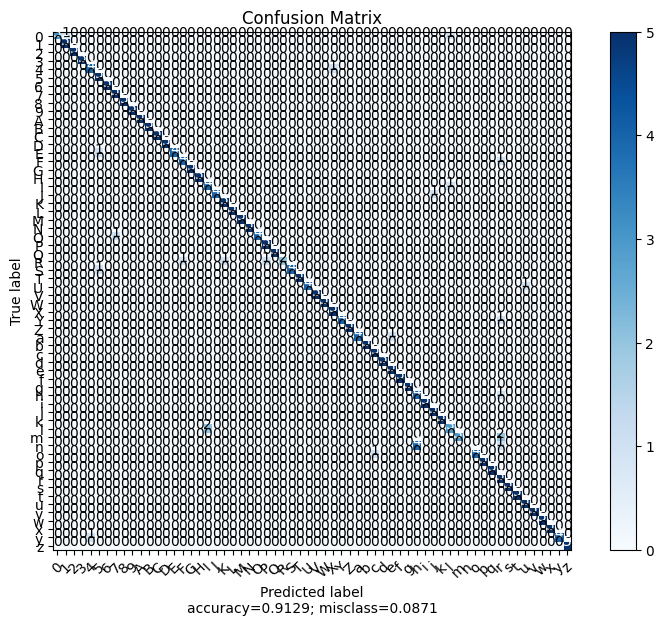

In [154]:
# Prediction
pred=model.predict(x=test_batches,verbose=0)
cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(pred,axis=1))
newPlotLabels= []
for i in range(48,58):
    newPlotLabels.append(chr(i))
for i in range(65,91):
    newPlotLabels.append(chr(i))
for i in range(97,123):
    newPlotLabels.append(chr(i))
plot_confusion_matrix(cm=cm,target_names=newPlotLabels,title='Confusion Matrix',normalize=False)

In [103]:
def save_image(s):
    import os
    import requests
    import numpy
    base="https://aims.iith.ac.in/aims/captcha/getCaptchaByString/"
    url = base + s
    r = requests.get(url, stream = True)
    if r.status_code == 200:
        r.raw.decode_content = True
        with open(os.path.join(os.getcwd(),"1#.jpg"),'wb') as f:
            shutil.copyfileobj(r.raw, f)
    else:
        return False
    return True

def model_predict(s):
    """
    s should be a 5 character long string
    """
    if (save_image(s)):
        out = ""
        img = load_img('1#.jpg', target_size=(50,150))
        img_arr = img_to_array(img)
        for i in range(5):
            img1 = img_arr[:,30*i:30*(i+1),:]
            img1 = keras.applications.mobilenet.preprocess_input(img1)
            img1 = img1.reshape((1, img1.shape[0], img1.shape[1], img1.shape[2]))
            pred=model.predict(img1,verbose=0)
            ind = np.where(pred[0]==1.0)[0][0]
            if (ind<10):
                out+=chr(ind+48)
            elif (ind<36):
                out+= chr(ind+55)
            else: out+= chr(ind+61)
        plt.imshow(img)
        print(f"Predicted string: {out}")
        os.remove("1#.jpg")
        plt.show()
    else:
        print('Image Couldn\'t be retreived')

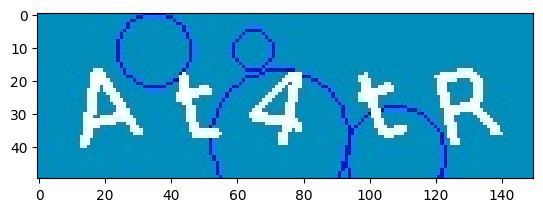

In [70]:
img = load_img(f'1.jpeg', target_size=(50,150))
plt.imshow(img)
plt.show()

In [71]:
img_arr = img_to_array(img)

10
55
4
55
27
At4tR


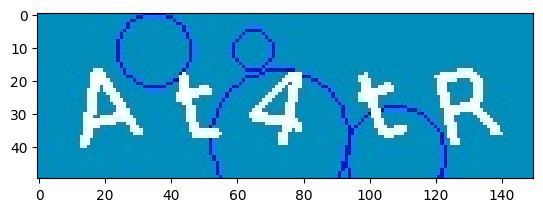

In [81]:
img = load_img(f'1.jpeg', target_size=(50,150))
img_arr = img_to_array(img)
out = ""
for i in range(5):
    img1 = img_arr[:,30*i:30*(i+1),:]
    img1 = keras.applications.mobilenet.preprocess_input(img1)
    img1 = img1.reshape((1, img1.shape[0], img1.shape[1], img1.shape[2]))
    pred=model.predict(img1,verbose=0)
    ind = np.where(pred[0]==1.0)[0][0]
    print(ind)
    if (ind<10):
        out+=chr(ind+48)
    elif (ind<36):
        out+= chr(ind+55)
    else: out+= chr(ind+61)
plt.imshow(img)
print(out)
plt.show()

In [74]:
img_arr.shape

(50, 150, 3)

In [63]:
img1 = img_arr[:,:30,:]
img1 = img1.reshape((1, img1.shape[0], img1.shape[1], img1.shape[2]))
pred=model.predict(img1,verbose=0)
print(pred)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [60]:
img1.shape

(50, 30, 3)

In [67]:
np.where(pred[0]==1.0)[0][0]

32

In [79]:
97-36

61

In [109]:
model_predict("A0oRU")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [155]:
def model_predict(fileName):
    img = load_img(f'random_test/{fileName}', target_size=(50,150))
    img_arr = img_to_array(img)
    out = ""
    for i in range(5):
        img1 = img_arr[:,30*i:30*(i+1),:]
        
        img1 = keras.applications.mobilenet.preprocess_input(img1)
        img1 = img1.reshape((1, img1.shape[0], img1.shape[1], img1.shape[2]))
        pred=model.predict(img1,verbose=0)
        pred = np.rint(pred)
        ind = np.where(pred[0])[0][0]
        if (ind<10):
            out+=chr(ind+48)
        elif (ind<36):
            out+= chr(ind+55)
        else: out+= chr(ind+61)
    plt.imshow(img)
    print(f"Predicted string: {out}")
    plt.show()

Predicted string: 0cPQx


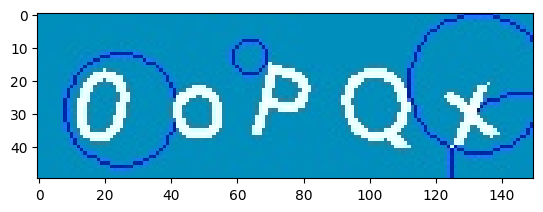

In [157]:
model_predict('7.jpeg')

0
50
25
26
59
0oPQx


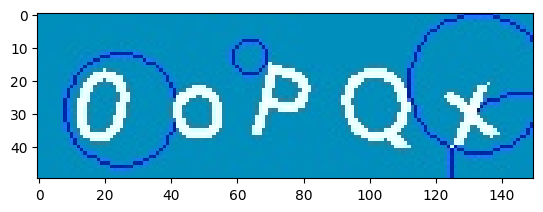

In [144]:
img = load_img(f'random_test/7.jpeg', target_size=(50,150))
img_arr = img_to_array(img)
out = ""
for i in range(5):
    img1 = img_arr[:,30*i:30*(i+1),:]
    img1 = keras.applications.mobilenet.preprocess_input(img1)
    img1 = img1.reshape((1, img1.shape[0], img1.shape[1], img1.shape[2]))
    pred=model.predict(img1,verbose=0)
    pred = np.rint(pred)
    ind = np.where(pred[0]==1.0)[0][0]
    print(ind)
    if (ind<10):
        out+=chr(ind+48)
    elif (ind<36):
        out+= chr(ind+55)
    else: out+= chr(ind+61)
plt.imshow(img)
print(out)
plt.show()